### Install Requirements

In [ ]:
# Run this cell to install the required packages
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

# If requirements.txt is present, switch the commented line
!pip3 install gdown==5.2.0 ipykernel==6.29.5 monai==1.4.0 nibabel==5.3.2 pip==25.0 PySocks==1.7.1 scikit-learn==1.6.1 seaborn==0.13.2
# !pip3 install -r requirements.txt

### Import Libraries

In [1]:
import os
import gdown
import torch
import numpy as np
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as transforms

from scipy.ndimage import zoom
from sklearn.metrics import confusion_matrix

from monai.networks.nets import EfficientNetBN, Densenet121

### Download trained model weights

In [ ]:
state_dict_url = "https://drive.google.com/uc?export=download&id=1PJ7LPEWIiH9DU45lCLF93plnCIqFst8m"

# download using gdown
gdown.download(state_dict_url, "./trained_effb0.zip", quiet=False)

!unzip -o "./trained_effb0.zip" -d "./"

Downloading...
From: https://drive.google.com/uc?export=download&id=1PJ7LPEWIiH9DU45lCLF93plnCIqFst8m
To: e:\U\S\01 - 4031\IABI\Proj\Inference\trained_effb0.zip
100%|██████████| 15.2M/15.2M [00:02<00:00, 5.46MB/s]


Archive:  ./trained_effb0.zip
  inflating: ./trained_effb0.pth     


### Set data and label csv directory paths

In [10]:
label_dir = './lgg_labels.csv'
input_dir = "./test_data"

### Load the trained model, and data

In [11]:
mean = [73.42668914794922]
std = [288.2677307128906]


inference_transform = transforms.Compose([
    transforms.Normalize(mean=mean, std=std),
])

model = EfficientNetBN(model_name="efficientnet-b0",
                       spatial_dims=2, in_channels=112, num_classes=1)
model.load_state_dict(torch.load("./trained_effb0.pth"))

<All keys matched successfully>

In [4]:
# read labels from label_dir
labels = []
with open(label_dir, 'r') as f:
    for line in f:
        labels.append(line.strip())

# process the labels
labels.pop(0)
labels = [i.split(',')[0] for i in labels]

# convert elements of labels as follows: "Co-deletion" -> 0, "d/d" -> 0, "intact" -> 1, "n/n" -> 1
for i in range(len(labels)):
    if labels[i] == "Co-deletion" or labels[i] == "d/d":
        labels[i] = 0
    else:
        labels[i] = 1

print(labels)

[0, 1, 1, 0, 1]


### Preprocess Data
##### (Assuming the data has been properly preprocessed by the given standards of the project)

In [ ]:
def remove_black_slices(img):
    """Removes black slices (slices with all pixel values equal to 0) from a preloaded NIfTI image.

    Args:
        img: Preloaded NIfTI image.

    Returns:
        The modified NIfTI image (or None if an error occurs).
    """
    try:
        img_data = img.get_fdata()

        # Calculate sum of all pixels in each slice
        slice_sums = np.sum(img_data, axis=(0, 1))

        # Identify slices to keep (non-zero sum)
        slices_to_keep = np.where(slice_sums != 0)[0]

        # Extract those slices
        new_data = img_data[:, :, slices_to_keep]

        # Create a new NIfTI image with updated data
        new_affine = img.affine.copy()
        # Modify affine to reflect changes in z-axis dimension
        new_affine[2, 3] = new_affine[2, 3] + \
            slices_to_keep[0]  # Or appropriate adjustment

        new_img = nib.Nifti1Image(new_data, new_affine, header=img.header)
        # Update header's dimensions
        new_img.header.set_data_shape(new_data.shape)

        return new_img
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

### Preprocess Data
##### (Assuming the data has been properly preprocessed by the given standards of the project)

In [ ]:
def duplicate_slices(data, target_slices):
    """
    If the image has less than half of the target slices, duplicate slices to improve interpolation quality.

    Parameters:
        data (numpy array): The 3D MRI data.
        target_slices (int): The desired number of slices.

    Returns:
        numpy array: The expanded data before interpolation.
    """
    current_slices = data.shape[2]

    if current_slices < target_slices / 2:
        # Determine duplication factor
        factor = int(target_slices // current_slices)
        expanded_data = np.repeat(data, factor, axis=2)

        # If still below the target, add one more duplication pass
        while expanded_data.shape[2] < target_slices / 2:
            expanded_data = np.repeat(expanded_data, 2, axis=2)

        return expanded_data
    return data

In [ ]:
def interpolate_nifti_image(nii, target_slices=64, order=3):
    """
    Interpolates a NIfTI image to have a uniform number of slices, handling very thin images with duplication first.

    Parameters:
        nii (nib.Nifti1Image): Preloaded NIfTI image.
        target_slices (int): Desired number of slices.
        order (int): Interpolation order (default is 3 for cubic).

    Returns:
        nib.Nifti1Image: Interpolated NIfTI image.
    """
    data = nii.get_fdata()

    # Handle very thin images by duplicating slices before interpolation
    data = duplicate_slices(data, target_slices)

    # Compute scale factors for interpolation
    scale_factors = (1, 1, target_slices / data.shape[2])

    # Apply interpolation
    resampled_data = zoom(data, scale_factors, order=order)

    # Create the new NIfTI image
    new_nii = nib.Nifti1Image(
        resampled_data, affine=nii.affine, header=nii.header)

    return new_nii

### Calculate outputs

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

In the following plot, '+' means intact (n/n), and '-' means codeleted (d/d).


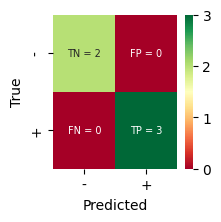

In [ ]:
# create a list of all the folders directly inside the input directory
subdirs = [os.path.join(input_dir, x) for x in os.listdir(
    input_dir) if os.path.isdir(os.path.join(input_dir, x))]

data = []

# each directory in subdirs contains a two nii files, one for T1, and one for T2 image. Load them
for idx, subdir in enumerate(subdirs):
    sample = {'id': idx,
              'filepath': subdir,
              'label': labels[idx]}
    # get the list of files in the subdirectory
    files = os.listdir(subdir)
    t1_path = [x for x in files if 't1c' in x][0]
    t2_path = [x for x in files if 't2w' in x][0]

    t1_img = nib.load(subdir + "/" + t1_path)
    t2_img = nib.load(subdir + "/" + t2_path)

    # remove black slices
    t1_img = remove_black_slices(t1_img)
    t2_img = remove_black_slices(t2_img)

    # interpolate the images to have 56 slices
    t1_img = interpolate_nifti_image(t1_img, target_slices=56)
    t2_img = interpolate_nifti_image(t2_img, target_slices=56)

    # get the image data
    t1_img = t1_img.get_fdata()
    t2_img = t2_img.get_fdata()

    # convert the images to float tensor
    t1_img = torch.tensor(t1_img).float()
    t2_img = torch.tensor(t2_img).float()

    # normalize the images using torchvision transforms
    t1_img = inference_transform(t1_img)
    t2_img = inference_transform(t2_img)

    # concat the images
    img_data = [t1_img, t2_img]
    img_data = torch.cat(img_data, dim=2)
    img_data = img_data.permute(2, 0, 1)

    output = model(img_data.unsqueeze(0))
    pred = (output >= 0).float()
    sample['prediction'] = pred.item()

    data.append(sample)

# calculate confusion matrix
y_true = [x['label'] for x in data]
y_pred = [x['prediction'] for x in data]
cm = confusion_matrix(y_true, y_pred)

# calculate accuracy, precision, recall, and F1-score
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# print the metrics nicely
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}", end='\n\n')


# plot the confusion matrix
# modify the confusion matrix to include labels
print("In the following plot, '+' means intact (n/n), and '-' means codeleted (d/d).")
cm_with_labels = np.array([[f"TN = {tn}", f"FP = {fp}"],
                           [f"FN = {fn}", f"TP = {tp}"]])

sns.heatmap(cm, annot=cm_with_labels, cmap='RdYlGn',
            fmt='', annot_kws={"size": 7})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0.5, 1.5], ['-', '+'])
plt.yticks([0.5, 1.5], ['-', '+'])
plt.gcf().set_size_inches(2, 2)